In [2]:
import gymnasium as gym
import numpy as np
gym.__version__

'0.29.0'

In [3]:
env = gym.make("LunarLander-v2")

# REINFORCE with Baseline

We're going to pick things up where we left off: a working shallow REINFORCE network.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize policy network
# takes in a state, determines the next action
class PolicyNetwork(nn.Module):
    def __init__(self, obs_size, action_size):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(obs_size, action_size, bias=False),
            nn.ReLU()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.layer(x)
        return torch.log(F.softmax(logits, dim=-1) + 1e-9)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        log_probs = self.forward(state).squeeze(0)
        probs = torch.exp(log_probs)
        action = torch.multinomial(probs, 1)
        return action.item(), log_probs[action]
    
model = PolicyNetwork(env.observation_space.shape[0], (env.action_space.n - env.action_space.start))

In [5]:
# takes in a state, estimates the value of the state v(s)
class StateValueNetwork(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, state):
        return self.layer(torch.tensor(state))
    
model = StateValueNetwork(env.observation_space.shape[0])
observation, _ = env.reset()
model(observation)

tensor([-0.0769], grad_fn=<AddBackward0>)

In [45]:
def run_episode(model, env=env, max_steps=1000):
    observation, _ = env.reset()

    rewards = []
    log_probs = []
    actions = []
    observations = []

    steps = 0

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        steps += 1

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

        if steps >= max_steps:
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

del model, rewards, log_probs, actions, observations

In [46]:
def discount_rewards(rewards, gamma=.99):
    G = []
    R = 0
    for i in reversed(range(len(rewards))):
        R = rewards[i] + gamma * R
        G.insert(0, R)
    return G


In [47]:
def update_with_baseline(policy_model, state_value_model, log_probs, discounted_rewards, observations, alpha=0.01, gamma=.99):
    for (t, log_prob, reward, state) in zip(range(len(log_probs)), log_probs, discounted_rewards, observations):
        
        # update for the state value model
        baseline = state_value_model(state)
        state_value_model.optimizer.zero_grad() # reset the gradients
        baseline.backward()
        
        for param in state_value_model.parameters():
            if param.grad is not None:
                alpha = .1 / torch.mean(param.grad**2)
                param.grad = alpha * (reward - baseline) * param.grad
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        state_value_model.optimizer.step() # update the weights using the gradients

        # updates for the policy model
        policy_model.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients for each log pi(A_t, S_t, theta)

        for param in policy_model.parameters():
            if param.grad is not None:
                param.grad = alpha * (reward - baseline) * gamma**t * param.grad   # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        policy_model.optimizer.step() # update the weights using the gradients

policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
state_value = StateValueNetwork(env.observation_space.shape[0])
rewards, log_probs, actions, observations = run_episode(model)
update_with_baseline(policy, state_value, log_probs, discount_rewards(rewards), observations)

NameError: name 'model' is not defined

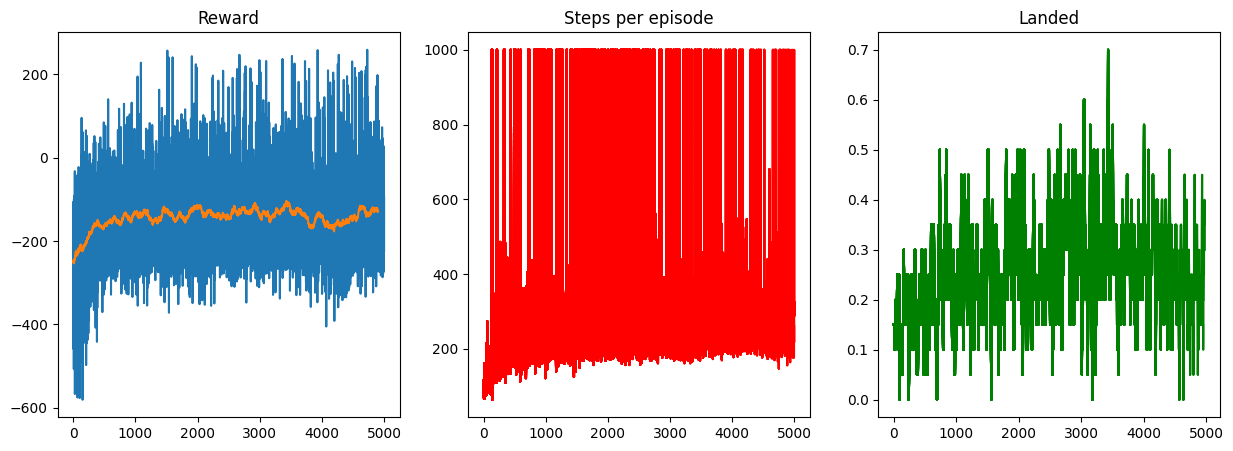

In [49]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
policy = PolicyNetwork(*network_shape)
state = StateValueNetwork(env.observation_space.shape[0])

rewards_track = []
steps_per_episode = []
landed = []

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(policy)
    update_with_baseline(policy, state, log_probs, rewards, observations)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]

    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 20:
            smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
            ax3.plot(smoothed, color='green')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

ax.clear()
ax.plot(rewards_track)
ax.set_title("Reward")

# add a smoothed version
if len(rewards_track) > 100:
    smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
    ax.plot(smoothed)

# also plot the number of steps
ax2.plot(steps_per_episode, color='red')
ax2.set_title("Steps per episode")

# and the number of times we landed
ax3.set_title("Landed")
if len(landed) > 20:
    smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
    ax3.plot(smoothed, color='green')

display(fig)

Alright, so something is broken in our implementation of the state value. Let's try to fix it. Good first check is on the gradients. Are they flowing?

In [50]:
# print the percentage that are near 0
def show_grads(model, tol=1e-2):
    return sorted([(name, f"{100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())}%") for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

print(show_grads(state))
print(show_grads(policy))

[('layer.0.weight', '1.07421875%'), ('layer.2.weight', '0.78125%'), ('layer.0.bias', '0.0%'), ('layer.2.bias', '0.0%')]
[('layer.0.weight', '0.0%')]


So none of our gradients are at 0. That's good. Let's check how they're distributed. Ideally, we want them to be centered around 0 and have a small variance. This means that the gradients are neither too big nor too small, and that they're both positive and negative.

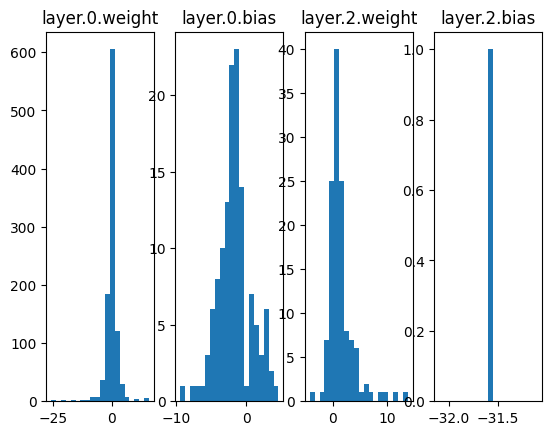

In [51]:

fig, ax = plt.subplots(1, len(list(state.parameters())))
for (i, (name, param)) in enumerate(state.named_parameters()):
    # set the subplot title to be the parameter name
    ax[i].set_title(name)
    # plot the parameter values
    ax[i].hist(param.flatten().detach().numpy(), bins=20)

The values network should be converging to the true values of the states. The way in which we can determine this is by looking at the difference between the reward for the state and the value for the state, and they should get closer.

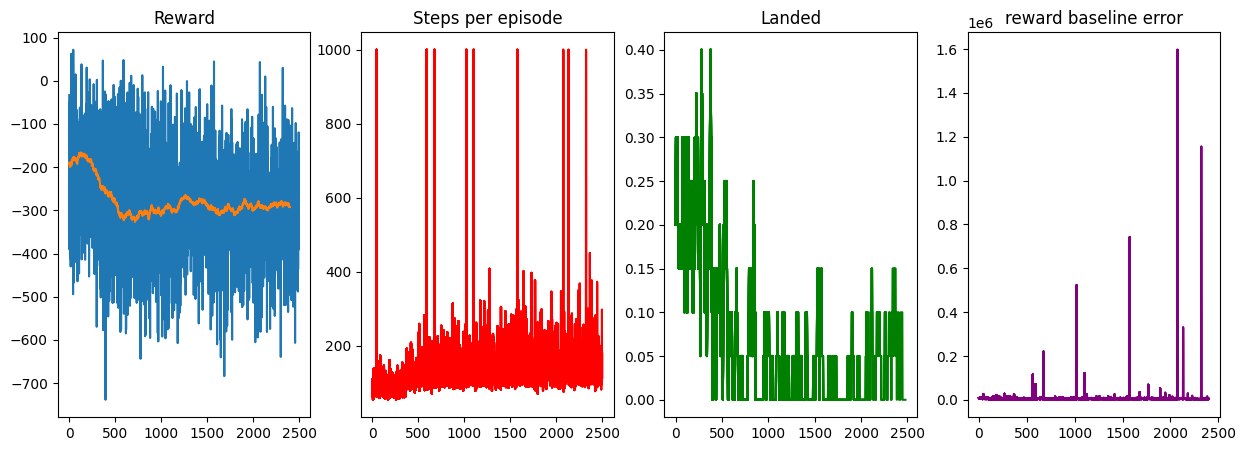

In [62]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
policy = PolicyNetwork(*network_shape)
state = StateValueNetwork(env.observation_space.shape[0])

rewards_track = []
steps_per_episode = []
landed = []
state_mse = []

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

for i in range(2500):
    rewards, log_probs, actions, observations = run_episode(policy)

    estimated_values = [state(observation) for observation in observations]
    state_mse += [.5 * sum((rewards - torch.Tensor(estimated_values)) ** 2)]
    
    update_with_baseline(policy, state, log_probs, rewards, observations)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]

    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 20:
            smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
            ax3.plot(smoothed, color='green')

        ax4.set_title("reward baseline error")
        ax4.plot(state_mse, color='purple')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

ax.clear()
ax.plot(rewards_track)
ax.set_title("Reward")

# add a smoothed version
if len(rewards_track) > 100:
    smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
    ax.plot(smoothed)

# also plot the number of steps
ax2.plot(steps_per_episode, color='red')
ax2.set_title("Steps per episode")

# and the number of times we landed
ax3.set_title("Landed")
if len(landed) > 20:
    smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
    ax3.plot(smoothed, color='green')

display(fig)